# Walmart Weekly Sales Regression

eeshanis

2/5/2026

In this assignment, you will predict **Weekly_Sales** using tabular store/economic features.

To keep things focused, you will do **only one preprocessing mode**:

- **scale_all_after_ohe**: one-hot encode categorical features, then standardize *all* resulting features.

Then you will train and evaluate **four models** using **fixed hyperparameters** (no grid search):
- Elastic Net
- K-Nearest Neighbors (KNN)
- Decision Tree (DT)
- Random Forest (RF)

---

## Submission guidelines
- Complete all **[TODO]** blocks in this notebook.
- Push the finished notebook to your **GitHub repository**.
- Submit the **GitHub link** on the Canvas submission page.




## Setup

Run the next cell to import libraries and define helper functions.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_regression(model, X_train, X_test, y_train, y_test):
    """Fit on train, evaluate on test."""
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, pred),
        "RMSE": rmse(y_test, pred),
        "R2": r2_score(y_test, pred),
    }

# Reproducibility
RANDOM_STATE = 42


## Load data

- Put the dataset CSV in the **same folder** as this notebook (recommended), or provide an absolute path.
- We drop the **Date** column (if present).
- We treat **Store** and **Holiday_Flag** as categorical.


In [2]:
# === Data path ===
DATA_PATH = "/content/Walmart_Store_sales.csv"

# Load
df = pd.read_csv(DATA_PATH)

# Drop Date
if "Date" in df.columns:
    df = df.drop(columns=["Date"])

# Target and features
y = df["Weekly_Sales"]
X = df.drop(columns=["Weekly_Sales"])

# Treat these as categorical
for col in ["Store", "Holiday_Flag"]:
    if col in X.columns:
        X[col] = X[col].astype(str)

display(df.head())
print("Shape:", df.shape)


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,1554806.68,0,46.50,2.625,211.350143,8.106


Shape: (6435, 7)


## Train/test split

We keep a standard **80/20 random split**.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (5148, 6) Test: (1287, 6)


## Preprocessing: scale_all_after_ohe

Goal:
1) One-hot encode categorical columns (so everything becomes numeric)
2) Standardize **all** resulting features

You will build a preprocessing pipeline that you can reuse for all four models.


In [4]:
# --- Identify categorical and numeric columns ---
# We will treat Store and Holiday_Flag as categorical.
# All other columns are numeric (for this dataset).

cat_cols = ["Store", "Holiday_Flag"]
num_cols = []

for col in X_train.columns:
    if col not in cat_cols:
        num_cols.append(col)

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# --- Build scale_all_after_ohe preprocessing pipeline ---
ohe = OneHotEncoder(handle_unknown="ignore")

## [ TODO ]
# Create a ColumnTransformer that:
# - applies One-hot encoding (OHE) to cat_cols
# - passes through num_cols unchanged
# Then apply StandardScaler(with_mean=False) to scale all features.
#
# Name the final pipeline variable: `prep_A`
#
# Hint: ColumnTransformer(..., remainder="drop")
# Hint: StandardScaler(with_mean=False) is sparse-friendly.

# column transfer that applied ohe to cat columns only
prep_A = ColumnTransformer(
                transformers=[
                  ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
                  ("num", "passthrough", num_cols),
                  ],
                  remainder="drop"
)

# scaling the features
prep_A = Pipeline(
    steps=[
        ("ohe", prep_A),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

PREP_MODES = {
    "scale_all_after_ohe": prep_A
}

Categorical columns: ['Store', 'Holiday_Flag']
Numeric columns: ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


## Implementation of Regression Models

Create 4 pipelines, each with:
- `("prep", prep_A)`
- `("model", <your model with fixed params>)`

**Use the exact parameters below:**
- RandomForestRegressor: `n_estimators=200`, `max_depth=None`, `max_features="sqrt"`, `min_samples_leaf=1`
- KNeighborsRegressor: `n_neighbors=15`, `weights="distance"`
- ElasticNet: `alpha=0.001`, `l1_ratio=0.9`
- DecisionTreeRegressor: `max_depth=None`, `min_samples_leaf=10`


In [5]:
## [ TODO ]
# Build the 4 pipelines below.
#
# Notes:
# - For ElasticNet, it can help to raise max_iter to avoid convergence warnings.
# - For DT/RF, set random_state=RANDOM_STATE for reproducibility.

rf_pipe = Pipeline(steps=[
    ("prep", prep_A),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1,
                                    n_estimators=200, max_depth=None,
                                    max_features="sqrt", min_samples_leaf=1)),
])

knn_pipe = Pipeline(steps=[
    ("prep", prep_A),
    ("model", KNeighborsRegressor(n_neighbors=15, weights="distance")),
])

enet_pipe = Pipeline(steps=[
    ("prep", prep_A), # scaled
    ("model", ElasticNet(random_state=RANDOM_STATE,
                         max_iter=200000, alpha=0.001,
                         l1_ratio=0.9)),
])

dt_pipe = Pipeline(steps=[
    ("prep", prep_A),
    ("model", DecisionTreeRegressor(random_state=RANDOM_STATE,
                                    max_depth=None, min_samples_leaf=10)),
])

MODELS = {
    "RandomForest": rf_pipe,
    "KNN": knn_pipe,
    "ElasticNet": enet_pipe,
    "DecisionTree": dt_pipe,
}

MODELS


{'RandomForest': Pipeline(steps=[('prep',
                  Pipeline(steps=[('ohe',
                                   ColumnTransformer(transformers=[('cat',
                                                                    OneHotEncoder(handle_unknown='ignore'),
                                                                    ['Store',
                                                                     'Holiday_Flag']),
                                                                   ('num',
                                                                    'passthrough',
                                                                    ['Temperature',
                                                                     'Fuel_Price',
                                                                     'CPI',
                                                                     'Unemployment'])])),
                                  ('scaler', StandardScaler(with_mean=False))

## Evaluation (CV RMSE + test metrics)

Following code block computes:
- **5-fold CV RMSE** on the *training set* (for a fair comparison)
- **test MAE / RMSE / R²** after fitting on the full training set


In [6]:
# 5-fold CV (shuffle for reproducibility)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []

for name, pipe in MODELS.items():
    # --- CV RMSE ---
    # cross_val_score returns NEGATIVE values when using neg_root_mean_squared_error.
    cv_scores = cross_val_score(
        pipe,
        X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=1
    )
    cv_rmse = -cv_scores.mean()

    # --- Test metrics ---
    metrics = evaluate_regression(pipe, X_train, X_test, y_train, y_test)

    rows.append({
        "Preprocess": "scale_all_after_ohe",
        "Model": name,
        "Best CV RMSE": cv_rmse,
        "MAE": metrics["MAE"],
        "RMSE": metrics["RMSE"],
        "R2": metrics["R2"],
    })

results_df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
display(results_df)


,Preprocess,Model,Best CV RMSE,MAE,RMSE,R2
0,scale_all_after_ohe,RandomForest,143009.116960,71713.708493,137951.356409,0.940927
1,scale_all_after_ohe,KNN,152200.243436,77729.980038,145549.240578,0.934241
2,scale_all_after_ohe,ElasticNet,161200.030473,91010.225646,159673.110790,0.920859
3,scale_all_after_ohe,DecisionTree,160738.282128,89116.114675,164038.204310,0.916473


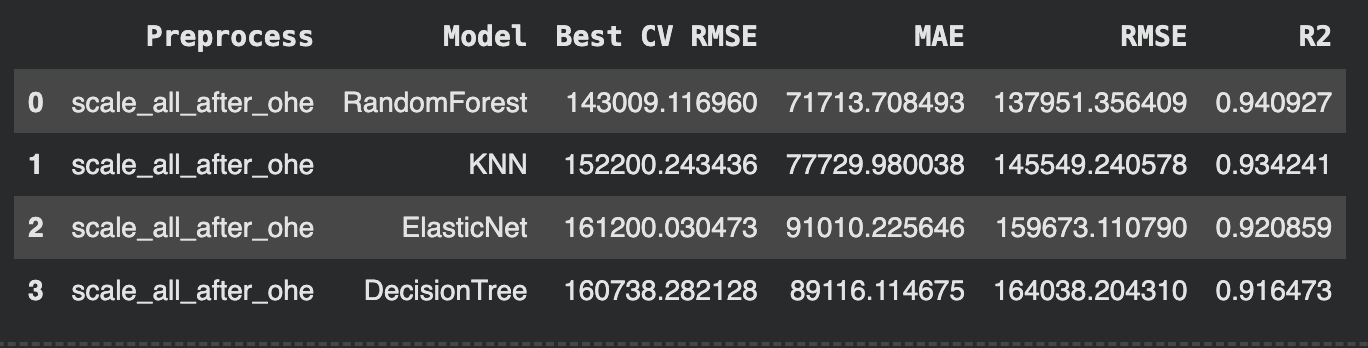

## Model Stacking (Decision Tree + Elastic Net)

A single model might miss patterns that another model captures well.
- **Decision Tree** can learn nonlinear splits and feature interactions.
- **Elastic Net** is a strong regularized linear model.

**Stacking** trains multiple base models, then trains a final model (a *meta-learner*) on their predictions.
Here we stack:
- base models: **Decision Tree + Elastic Net**
- meta-learner: **Ridge regression**

We use `cv=5` so the meta-learner is trained on out-of-fold predictions (more realistic and less leakage).


In [7]:
#imports for stacking dt and elastic net
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge


In [9]:
# --- Stacking (DT + ElasticNet) ---

prep = PREP_MODES["scale_all_after_ohe"]

## [ TODO ]
# 1) Create `enet_best` as a Pipeline:
#    ("prep", prep) -> ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=10000))
#
enet_best = Pipeline(steps=[
    ("prep", prep_A),
    ("model", ElasticNet(alpha=0.001,
                         l1_ratio=0.5,
                         random_state=RANDOM_STATE,
                         max_iter=10000)),
    ])
# 2) Create `dt_best` as a Pipeline:
#    ("prep", prep) -> ("model", DecisionTreeRegressor(max_depth=None, min_samples_leaf=10, random_state=42))
#

dt_best = Pipeline(steps=[
    ("prep", prep_A),
    ("model", DecisionTreeRegressor(max_depth=None,
                                    min_samples_leaf=10,
                                    random_state=RANDOM_STATE)),
    ])

# 3) Create `stack` as a StackingRegressor:
#    estimators=[("dt", dt_best), ("enet", enet_best)]
#    final_estimator=Ridge(alpha=0.9)
#    cv=5
#    n_jobs=1

stack = StackingRegressor(estimators=[("dt", dt_best), ("enet", enet_best)],
                          final_estimator=Ridge(alpha=0.9),
                          cv=5,
                          n_jobs=1)

# raise NotImplementedError("Complete the stacking TODOs above.")

## [ TODO ]
# 4) Fit on (X_train, y_train), then predict on test.
# stack_model = stack.fit(X_train, y_train)
# y_pred = stack_model.predict(X_test)
# 5) Print MAE, RSME, R^2, metrics for the X_test.

evaluate_regression(stack, X_train, X_test, y_train, y_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27883891218669.57, tolerance: 163457864416.10596
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22296152462502.92, tolerance: 131523352296.64708
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23124810613449.484, tolerance: 132434725424.95358
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: Conv

{'MAE': 83714.81505727435,
 'RMSE': np.float64(154524.16984984995),
 'R2': 0.9258811710616842}

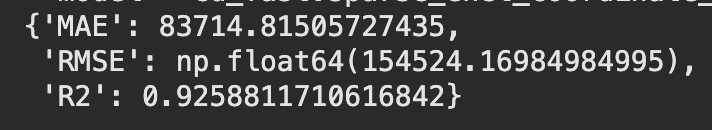